In [1]:
pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import tarfile
import os
import xgboost as xgb
import statsmodels.api as sm
import pickle
import statistics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "search-algorithm-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")
sm_autoscaling_client = boto3.client("application-autoscaling")

sagemaker_role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
def read_glue_table(database_name, table_name):
    # Create Glue client
    glue_client = boto3.client('glue')

    # Get the Glue table metadata
    response = glue_client.get_table(DatabaseName=database_name, Name=table_name)
    location = response['Table']['StorageDescriptor']['Location']

    # Read data from the Glue table into a Pandas DataFrame
    try:
        df = pd.read_parquet(location)
        if df.empty:
            raise ValueError("CSV file is empty")
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [5]:
# Load the saved model for inverse mills ratio
params = pd.read_csv('probit_params.csv', header=None, index_col=0)

# Load the saved model
with open('probit_result.pkl', 'rb') as f:
    probit_result = pickle.load(f)

In [6]:
main_df = read_glue_table('search_simulation', 'tutor_info')
check = read_glue_table('search_simulation', 'tutor_offering')
course_check = check[['school_year_id', 'course_id', 'school_type_id', 'school_level_id']].drop_duplicates()

In [7]:
# Set the S3 bucket and key where rethe model artifacts are stored
bucket_name = "algorithmsearch"
key_prefix = "Artifact/nl-full-xgb-model-output/sagemaker-xgboost-2024-05-07-15-54-27-851/output"

# Initialize a Boto3 client to interact with S3
s3 = boto3.client("s3")

# Define local directory to download the model artifacts
local_dir = "local_model"

# Create local directory if it doesn't exist
os.makedirs(local_dir, exist_ok=True)

# Download the model artifacts
model_tar_name = "model.tar.gz"
model_tar_path = os.path.join(local_dir, model_tar_name)
s3.download_file(bucket_name, f"{key_prefix}/{model_tar_name}", model_tar_path)

# Extract the model artifacts
with tarfile.open(model_tar_path, "r:gz") as tar:
    tar.extractall(path=local_dir)

# Assuming there's an extra directory level, find the correct path
extracted_dirs = os.listdir(local_dir)
if len(extracted_dirs) == 1:
    model_path = os.path.join(local_dir, extracted_dirs[0])
else:
    model_path = os.path.join(local_dir)

# Load the XGBoost model
model = xgb.Booster(model_file=os.path.join(model_path, "xgboost-model"))

In [8]:
school_year_id = [11,12,13,14,18,19]
course_id = [1,2,3,4,5,6,7,8,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36]
school_type_id = [8,9]
school_level_id = [3,4,5,13]

def random_student_generator(seed):
    np.random.seed(seed)
    new = np.random.choice([0, 1], p=[0.6, 0.4])
    created_deals = int(np.where(new == 1, 0, np.random.randint(1, 100, dtype=int)))
    online_lesson_rate = float(np.where(new == 1, 0, np.random.uniform(0.80, 1)))
    student_average_duration = float(np.where(new == 1, 60.0, np.random.uniform(50.0, 70.0)))

    while True:
        student_year = int(np.random.choice(school_year_id))
        student_course = int(np.random.choice(course_id))
        student_type = int(np.random.choice(school_type_id))
        student_school_level = int(np.random.choice(school_level_id))
        course_combination = np.array([student_year, student_course, student_type, student_school_level])
        if (course_combination == course_check.values).all(axis=1).any():
            break
    
    return np.array([created_deals, online_lesson_rate, student_average_duration, course_combination], dtype=object)

In [9]:
def search_process(seed):
    student = random_student_generator(seed)
    course_combination = np.array(student[3])
    tutor_check = (check[['school_year_id', 'course_id', 'school_type_id', 'school_level_id']] == course_combination).all(axis=1)
    available_tutors = check[tutor_check]
    correct_tutors = available_tutors[~available_tutors['tutor'].isin(tutor_student_count.keys()) | (available_tutors['tutor'].map(tutor_student_count) < 4)]
    correct_tutors = correct_tutors['tutor']
    tutor_info_buffer = main_df[main_df['tutor'].isin(correct_tutors)]
    if tutor_info_buffer.empty:
        columns = ['tutor', 'old_formula', 'tutor_type', 'new_formula', 'intro_success_rate', 'distance']
        empty_final = pd.DataFrame(columns=columns)
        return empty_final
    data = tutor_info_buffer.merge(available_tutors[['tutor', 'tutor_course_accepted_lessons']], on='tutor', how='left').drop_duplicates()

    student_stat = np.array([student[0], student[1], student[2]]).reshape(-1, 1)
    repeated_student_stat = np.repeat(student_stat, len(data), axis=1).T

    new_column_names = ['created_deals', 'online_lesson_rate', 'student_average_duration']
    for i, col_name in enumerate(new_column_names):
        data[col_name] = repeated_student_stat[:, i]
    data['previous_lesson'] = np.random.choice([0, 1], p=[0.98, 0.02], size = len(data))
    data['distance'] = np.where(np.random.uniform(0, 20, size=len(data)) > data['tutor_max_travel_distance'], 0, np.random.uniform(0, 20, size=len(data)))

    #multiplier to process the old ranking formula
    data['first_multiplier_lessons'] = (np.where(data['tutor_total_accepted_lessons'] > 50, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 70, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 100, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 140, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 210, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 280, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 330, 2, 1)) * \
                                  (np.where(data['tutor_total_accepted_lessons'] > 400, 2, 1))

    conditions = [
        (data['tutor_previous_number_of_students'] == 0) & (data['number_of_relations'] < 3),
        (data['tutor_previous_number_of_students'] == 1) & (data['tutor_total_accepted_lessons'] == 1),
        (data['tutor_previous_number_of_students'] != 0) 
    ]
    choices = [
        4,
        1,
        (((data['tutor_total_accepted_lessons'] / data['tutor_previous_number_of_students']) ** 2) / (data['tutor_previous_number_of_students'] ** 2.2)) * data['first_multiplier_lessons']
    ]
    default = 0

    data['first_multiplier'] = np.select(conditions, choices, default)
    data['first_multiplier'] = np.sqrt(data['first_multiplier'])

    data['second_multiplier'] = np.where(data['number_of_relations'] > 0, (1 + data['tutor_previous_number_of_students'])/data['number_of_relations'], 1.4)
    data['third_multiplier'] = np.where(data['tutor_has_availability'] == True, 1.2, 0.8)
    data['fourth_multiplier'] = np.where((data['tutor_previous_number_of_students'] == 0) & (data['number_of_relations'] < 3) & (data['tutor_days_to_first_lesson'] < 38), 8, 1)
    data['offline_multiplier'] = 2.2 * np.where(data['tutor_type'] == 1, 1, 1.3) + 1


    data['tutor_manual_weight'] = data['manual_weight'].fillna(1)
    data['online_rank_score'] = data['first_multiplier'] * data['second_multiplier'] * data['third_multiplier'] * data['fourth_multiplier'] * data['tutor_manual_weight']
    data['offline_rank_score'] = data['first_multiplier'] * data['second_multiplier'] * data['third_multiplier'] * data['fourth_multiplier'] * data['tutor_manual_weight']/data['offline_multiplier']
    data['old_formula'] = np.where(data['distance'] == 0, data['online_rank_score'], data['offline_rank_score'])

    data['tutor_type'] = data['tutor_type'].astype('str')
    data['tutor_can_teach_online'] = data['tutor_can_teach_online'].astype('bool')
    data['avg_lesson_per_student'] = data['avg_lesson_per_student'].astype('float')

    predicted_probabilities = probit_result.predict(exog=data)
    probit_lp = probit_result.fittedvalues
    mills_ratio = np.exp(-0.5 * probit_lp ** 2) / (np.sqrt(2 * np.pi) * predicted_probabilities)
    inverse_mills_ratio = 1 / mills_ratio
    data['inverse_mills_ratio'] = inverse_mills_ratio

    pred = data.drop(columns = ['tutor', 'country', 'first_multiplier_lessons', 'first_multiplier', 'second_multiplier', 'third_multiplier', 'fourth_multiplier', 'offline_multiplier', 'tutor_manual_weight', 'online_rank_score', 'offline_rank_score', 'manual_weight', 'number_of_relations'])
    pred['tutor_type'] = data['tutor_type'].astype('category')
    pred = pred[['tutor_total_accepted_lessons', 'tutor_course_accepted_lessons', 'tutor_average_duration', 'student_average_duration', 'created_deals', 'tutor_previous_number_of_students', 'tutor_total_intro_requests', 'tutor_total_accepted_intro_requests', 'availabile_hours', 'median_response_time', 'intros_leading_to_lesson', 'online_lesson_rate', 'previous_lesson', 'tutor_accepts_new_students', 'tutor_max_travel_distance', 'tutor_can_teach_online', 'tutor_has_availability', 'tutor_course_offerings_count', 'tutor_type', 'distance', 'tutor_days_to_first_lesson', 'avg_lesson_per_student', 'tutor_actual_cancellations', 'lessons_per_relation', 'old_formula', 'inverse_mills_ratio']]
    predictions = model.predict(xgb.DMatrix(pred, enable_categorical = True))
    final = pd.DataFrame(data['tutor'])
    final['old_formula'] = data['old_formula']
    final['tutor_type'] = data['tutor_type']
    final['new_formula'] = predictions.tolist()
    final['intro_success_rate'] = np.where(data['tutor_total_intro_requests'] != 0, data['tutor_total_accepted_intro_requests']/data['tutor_total_intro_requests'], 1)
    final['distance'] = data['distance']

    return final

In [10]:
def old_match_process(seed):
    tutor_score = search_process(seed)
    if tutor_score.empty:
        return None
    breakpoint()
    old_total = tutor_score['old_formula'].sum()
    tutor_score['old_prob'] = tutor_score['old_formula'] / old_total
    tutor_score['old_prob'] /= tutor_score['old_prob'].sum()
    if tutor_score['old_prob'].isna().any():
        return None
    non_zero_count = (tutor_score['old_prob'] != 0).sum()

    tutor_to_choose = np.random.randint(low=1, high=5)
    tutor_to_choose = min(tutor_to_choose, len(tutor_score), non_zero_count)

    chosen_indices = np.random.choice(tutor_score.index, size=tutor_to_choose, p=tutor_score['old_prob'], replace=False)
    chosen_tutors = tutor_score.loc[chosen_indices]

    success_chat = np.random.choice([0, 1], size=tutor_to_choose, p=[0.2, 0.8])
    chosen_tutors['pass'] = success_chat.tolist()
    chosen_tutors = chosen_tutors[chosen_tutors['pass'] != 0]
    
    if len(chosen_tutors) == 0:
        return None

    chosen_tutors = chosen_tutors.sort_values(by='old_prob')
    database_success_rate = [0.513, 0.547, 0.573]

    for i in range(len(chosen_tutors)):
        success_intro_rate = chosen_tutors['intro_success_rate'].iloc[i]
        tutor_type = int(chosen_tutors['tutor_type'].iloc[i]) - 1
        data_success_rate = database_success_rate[tutor_type]
        
        success_prob = data_success_rate * success_intro_rate
        success_intro = np.random.choice([0, 1], p=[1 - success_prob, success_prob])
        
        if success_intro == 1:
            the_chosen_tutor = chosen_tutors[['tutor', 'tutor_type', 'distance']].iloc[i]
            tutor = the_chosen_tutor['tutor']
            if tutor in tutor_student_count:
                tutor_student_count[tutor] += 1
            else:
                tutor_student_count[tutor] = 1
            return the_chosen_tutor
            
    return None


def new_match_process(seed):
    tutor_score = search_process(seed)
    if tutor_score.empty:
        return None
    new_total = tutor_score['new_formula'].sum()
    tutor_score['new_prob'] = tutor_score['new_formula'] / new_total
    tutor_score['new_prob'] /= tutor_score['new_prob'].sum()
    if tutor_score['old_prob'].isna().any():
        return None
    tutor_to_choose = np.random.randint(low=1, high=5)
    tutor_to_choose = min(tutor_to_choose, len(tutor_score))

    chosen_indices = np.random.choice(tutor_score.index, size=tutor_to_choose, p=tutor_score['new_prob'], replace=False)
    chosen_tutors = tutor_score.loc[chosen_indices]

    success_chat = np.random.choice([0, 1], size=tutor_to_choose, p=[0.2, 0.8])
    chosen_tutors['pass'] = success_chat.tolist()
    chosen_tutors = chosen_tutors[chosen_tutors['pass'] != 0]
    
    if len(chosen_tutors) == 0:
        return None

    chosen_tutors = chosen_tutors.sort_values(by='new_prob')
    database_success_rate = [0.513, 0.547, 0.573]

    for i in range(len(chosen_tutors)):
        success_intro_rate = chosen_tutors['intro_success_rate'].iloc[i]
        tutor_type = int(chosen_tutors['tutor_type'].iloc[i]) - 1
        data_success_rate = database_success_rate[tutor_type]
        
        success_prob = data_success_rate * success_intro_rate
        success_intro = np.random.choice([0, 1], p=[1 - success_prob, success_prob])
        
        if success_intro == 1:
            the_chosen_tutor = chosen_tutors[['tutor', 'tutor_type', 'distance']].iloc[i]
            tutor = the_chosen_tutor['tutor']
            if tutor in tutor_student_count:
                tutor_student_count[tutor] += 1
            else:
                tutor_student_count[tutor] = 1
            return the_chosen_tutor
            
    return None

In [11]:
def old_revenue(seed):
    result = old_match_process(seed)
    breakpoint()
    if result is None:
        return ('Lost student', 0, 0, 0)
    else:
        tutor_type = result.iloc[1]

        #Student and tutor agrees on a fixed lesson duration
        lesson_duration = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]
        count_duration = [476, 2380, 14758, 78468, 3899, 32003, 937, 5960, 280, 300, 33, 362, 52]
        lesson_duration_probability = [count / sum(count_duration) for count in count_duration]
        lesson_duration_choose = np.random.choice(lesson_duration, p=lesson_duration_probability)

        #Profit from each lesson, if student did single lessons
        available_single_lesson_profit = [10, 15, 20]
        this_student_single_lesson_profit = available_single_lesson_profit[int(result['tutor_type']) - 1]

        #Profit from package
        number_of_package_lessons = [13, 26]
        profit_13 = [117, 175.5, 234] #90% of single lesson proft
        profit_26 = [208, 312, 416] #80% of single lesson profit
        this_student_package_13_profit = profit_13[int(result['tutor_type']) - 1]
        this_student_package_26_profit = profit_26[int(result['tutor_type']) - 1]

        revenue = 0
        lesson_count = 0
        package_purchased = 0
    
        if lesson_count == 0:
            not_buy_package = 0.95
        elif lesson_count >= 15:
            not_buy_package = 0.9
        else:
            not_buy_package = 0.95 ** lesson_count

        student_continues_lesson = [1, 0.62, 0.74, 0.79, 0.82, 0.84, 0.85, 0.87, 0.87, 0.87, 0.87]

        while True:
            student_decides_to_buy_package = np.random.choice([0,1], p = [not_buy_package, 1 - not_buy_package])
            if student_decides_to_buy_package == 1:
                package_purchased += 1
                student_package_choice = np.random.choice([0,1], p = [0.6, 0.4]) #0 for 13, 1 for 26
                if student_package_choice == 0:
                    revenue += this_student_package_13_profit * lesson_duration_choose
                    lesson_count += number_of_package_lessons[student_package_choice]
                else:
                    revenue += this_student_package_26_profit * lesson_duration_choose
                    lesson_count += number_of_package_lessons[student_package_choice]
            elif lesson_count <= 10:
                student_does_single_lesson = np.random.choice([0, 1], p=[1 - student_continues_lesson[lesson_count], student_continues_lesson[lesson_count]])
                if student_does_single_lesson == 1:
                    revenue += this_student_single_lesson_profit * lesson_duration_choose
                    lesson_count += 1
                else:
                    return tutor_type, revenue, lesson_count, package_purchased, lesson_duration_choose
            elif 10 < lesson_count <= 140:
                student_does_single_lesson = np.random.choice([0, 1], p=[0.1, 0.9])
                if student_does_single_lesson == 1:
                    revenue += this_student_single_lesson_profit * lesson_duration_choose
                    lesson_count += 1
                else:
                    return tutor_type, revenue, lesson_count, package_purchased
            else:
                return tutor_type, revenue, lesson_count, package_purchased
            
    return tutor_type, revenue, lesson_count, package_purchased

def new_revenue(seed):
    result = old_match_process(seed)
    if result is None:
        return ('Lost student', 0, 0, 0)
    else:
        tutor_type = result.iloc[1]

        #Student and tutor agrees on a fixed lesson duration
        lesson_duration = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]
        count_duration = [476, 2380, 14758, 78468, 3899, 32003, 937, 5960, 280, 300, 33, 362, 52]
        lesson_duration_probability = [count / sum(count_duration) for count in count_duration]
        lesson_duration_choose = np.random.choice(lesson_duration, p=lesson_duration_probability)

        #Profit from each lesson, if student did single lessons
        available_single_lesson_profit = [10, 15, 20]
        this_student_single_lesson_profit = available_single_lesson_profit[int(result['tutor_type']) - 1]

        #Profit from package
        number_of_package_lessons = [13, 26]
        profit_13 = [117, 175.5, 234] #90% of single lesson proft
        profit_26 = [208, 312, 416] #80% of single lesson profit
        this_student_package_13_profit = profit_13[int(result['tutor_type']) - 1]
        this_student_package_26_profit = profit_26[int(result['tutor_type']) - 1]

        revenue = 0
        lesson_count = 0
        package_purchased = 0
    
        if lesson_count == 0:
            not_buy_package = 0.95
        elif lesson_count >= 15:
            not_buy_package = 0.9
        else:
            not_buy_package = 0.95 ** lesson_count

        student_continues_lesson = [1, 0.62, 0.74, 0.79, 0.82, 0.84, 0.85, 0.87, 0.87, 0.87, 0.87]

        while True:
            student_decides_to_buy_package = np.random.choice([0,1], p = [not_buy_package, 1 - not_buy_package])
            if student_decides_to_buy_package == 1:
                package_purchased += 1
                student_package_choice = np.random.choice([0,1], p = [0.6, 0.4]) #0 for 13, 1 for 26
                if student_package_choice == 0:
                    revenue += this_student_package_13_profit * lesson_duration_choose
                    lesson_count += number_of_package_lessons[student_package_choice]
                else:
                    revenue += this_student_package_26_profit * lesson_duration_choose
                    lesson_count += number_of_package_lessons[student_package_choice]
            elif lesson_count <= 10:
                student_does_single_lesson = np.random.choice([0, 1], p=[1 - student_continues_lesson[lesson_count], student_continues_lesson[lesson_count]])
                if student_does_single_lesson == 1:
                    revenue += this_student_single_lesson_profit * lesson_duration_choose
                    lesson_count += 1
                else:
                    return tutor_type, revenue, lesson_count, package_purchased
            elif 10 < lesson_count <= 140:
                student_does_single_lesson = np.random.choice([0, 1], p=[0.1, 0.9])
                if student_does_single_lesson == 1:
                    revenue += this_student_single_lesson_profit * lesson_duration_choose
                    lesson_count += 1
                else:
                    return tutor_type, revenue, lesson_count, package_purchased
            else:
                return tutor_type, revenue, lesson_count, package_purchased
            
    return tutor_type, revenue, lesson_count, package_purchased

In [12]:
def old_results(number_of_students):
    global tutor_student_count
    tutor_student_count = {}
    lost_student = 0
    total_revenue = 0
    total_lesson_count = 0
    total_package = 0
    student_with_packages = 0

    for i in range(1, number_of_students):
        seed = np.random.seed()
        old_result = old_revenue(seed)
        student_status = old_result[0]
        if student_status == 'Lost student':
            lost_student += 1
        else:
            total_revenue += old_result[1]
            total_lesson_count += old_result[2]
            total_package += old_result[3]
            if old_result[3] != 0:
                student_with_packages += 1
            
    matched_student = number_of_students - lost_student
    matched_student_rate = round(matched_student/number_of_students, 2)
    avg_lesson_per_student = float(np.where(matched_student != 0, round(total_lesson_count/matched_student,2), 0))

    return matched_student_rate, avg_lesson_per_student, total_package, student_with_packages, total_revenue, tutor_student_count


def new_results(number_of_students):
    global tutor_student_count
    tutor_student_count = {}
    lost_student = 0
    total_revenue = 0
    total_lesson_count = 0
    total_package = 0
    student_with_packages = 0
    
    for i in range(1, number_of_students):
        seed = np.random.seed()
        new_result = new_revenue(seed)
        if new_result[0] == 'Lost student':
            lost_student += 1
        else:
            total_revenue += new_result[1]
            total_lesson_count += new_result[2]
            total_package += new_result[3]
            if new_result[3] != 0:
                student_with_packages += 1
    
    matched_student = number_of_students - lost_student
    matched_student_rate = round(matched_student/number_of_students, 2)
    avg_lesson_per_student = float(np.where(matched_student != 0, round(total_lesson_count/matched_student,2), 0))

    return matched_student_rate, avg_lesson_per_student, total_package, student_with_packages, total_revenue, tutor_student_count

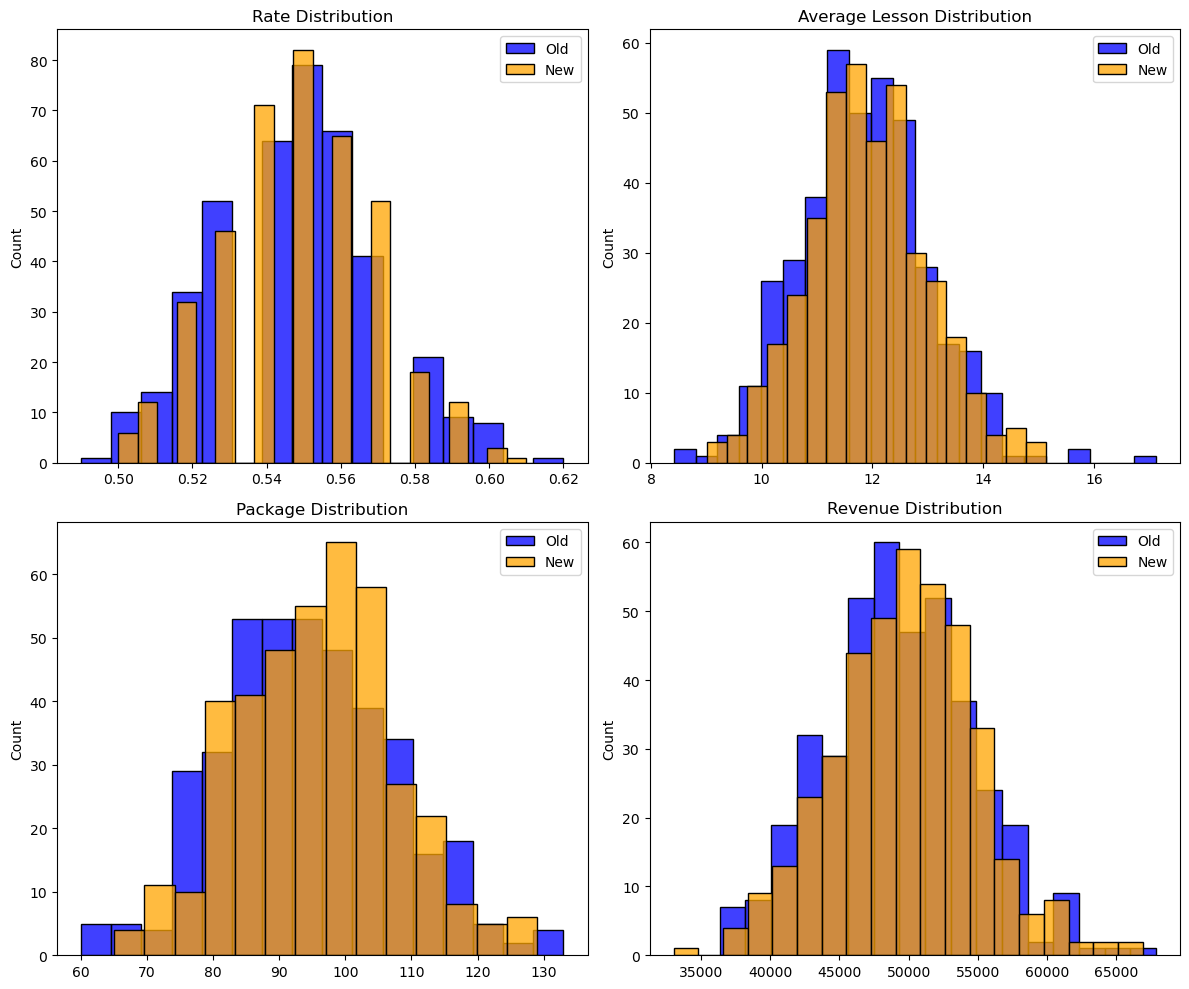

0.5478000000000001
11.83355
94.3375
62.13
49301.996875
137.21
1.9911558040515511
0.548875
11.92855
95.6775
62.5025
49755.4821875
137.17
1.9951711033831234


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

old_result_rate = []
old_result_avg_lesson = []
old_result_package = []
old_result_student_pkg = []
old_result_revenue = []
old_distinct_tutor = []
old_average_tutor_use = []

new_result_rate = []
new_result_avg_lesson = []
new_result_package = []
new_result_student_pkg = []
new_result_revenue = []
new_distinct_tutor = []
new_average_tutor_use = []

def simulation(seed, number_of_runs, number_of_students):
    np.random.seed(seed)
    for i in range(1, number_of_runs):
        old_results_data = old_results(number_of_students)
        old_tutor = old_results_data[5]
        old_distinct_tutor.append(len(old_tutor))
        old_average_tutor_use.append(sum(old_tutor.values())/len(old_tutor))
        
        new_results_data = new_results(number_of_students)
        new_tutor = new_results_data[5]
        new_distinct_tutor.append(len(new_tutor))
        new_average_tutor_use.append(sum(new_tutor.values())/len(new_tutor))
        
        # Append results to lists
        old_result_rate.append(old_results_data[0])
        old_result_avg_lesson.append(old_results_data[1])
        old_result_package.append(old_results_data[2])
        old_result_student_pkg.append(old_results_data[3])
        old_result_revenue.append(old_results_data[4])

        new_result_rate.append(new_results_data[0])
        new_result_avg_lesson.append(new_results_data[1])
        new_result_package.append(new_results_data[2])
        new_result_student_pkg.append(new_results_data[3])
        new_result_revenue.append(new_results_data[4])

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    
    # Plot rate distributions
    sns.histplot(old_result_rate, ax=axes[0, 0], color='blue', label='Old')
    sns.histplot(new_result_rate, ax=axes[0, 0], color='orange', label='New')
    axes[0, 0].set_title('Rate Distribution')
    axes[0, 0].legend()
    
    # Plot avg_lesson distributions
    sns.histplot(old_result_avg_lesson, ax=axes[0, 1], color='blue', label='Old')
    sns.histplot(new_result_avg_lesson, ax=axes[0, 1], color='orange', label='New')
    axes[0, 1].set_title('Average Lesson Distribution')
    axes[0, 1].legend()
    
    # Plot package distributions
    sns.histplot(old_result_package, ax=axes[1, 0], color='blue', label='Old')
    sns.histplot(new_result_package, ax=axes[1, 0], color='orange', label='New')
    axes[1, 0].set_title('Package Distribution')
    axes[1, 0].legend()
    
    # Plot student_pkg distributions
    sns.histplot(old_result_revenue, ax=axes[1, 1], color='blue', label='Old')
    sns.histplot(new_result_revenue, ax=axes[1, 1], color='orange', label='New')
    axes[1, 1].set_title('Revenue Distribution')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


simulation(100, 401, 500)
print(statistics.mean(old_result_rate))
print(statistics.mean(old_result_avg_lesson))
print(statistics.mean(old_result_package))
print(statistics.mean(old_result_student_pkg))
print(statistics.mean(old_result_revenue))
print(statistics.mean(old_distinct_tutor))
print(statistics.mean(old_average_tutor_use))

print(statistics.mean(new_result_rate))
print(statistics.mean(new_result_avg_lesson))
print(statistics.mean(new_result_package))
print(statistics.mean(new_result_student_pkg))
print(statistics.mean(new_result_revenue))
print(statistics.mean(new_distinct_tutor))
print(statistics.mean(new_average_tutor_use))